In [17]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

torch.manual_seed(42)

# -------------------------
# CONFIG
# -------------------------
TRAIN_FILE = "train.xlsx"
BATCH_SIZE = 128
EPOCHS = 20
LR = 0.01

# -------------------------
# DATASET
# -------------------------
class SwaptionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------------
# LOAD + PREPROCESS
# -------------------------
def load_and_prepare(filepath):
    df = pd.read_excel(filepath)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df = df.sort_values("Date").reset_index(drop=True)

    feature_cols = [c for c in df.columns if c != "Date"]
    data = df[feature_cols].values

    # NEXT-DAY prediction
    X_raw = data[:-1]
    y_raw = data[1:]

    # NORMALIZATION
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
    y = scaler.transform(y_raw)

    # NO PCA — NO TIME WINDOWS — NOTHING FANCY
    # JUST flatten (already flat, but kept for clarity)
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(y.shape[0], -1)

    return X, y, scaler


# Load dataset
X_all, y_all, scaler = load_and_prepare(TRAIN_FILE)

# Train/test split (chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=False
)

train_loader = DataLoader(SwaptionDataset(X_train, y_train),
                          batch_size=BATCH_SIZE, shuffle=True)
test_tensor = torch.tensor(X_test, dtype=torch.float32)

# -------------------------
# MODEL
# -------------------------
class LinearModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x):
        return self.linear(x)

model = LinearModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

training_losses = []
testing_losses = []
epochs = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    # Average training loss for this epoch
    train_loss = np.mean(batch_losses)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        preds_test_tensor = model(test_tensor)
        test_loss = criterion(preds_test_tensor, torch.tensor(y_test, dtype=torch.float32)).item()

    # Store history
    epochs.append(epoch + 1)
    training_losses.append(train_loss)
    testing_losses.append(test_loss)

    # Print per epoch
    print(f"Epoch {epoch+1}/{EPOCHS}  Train Loss={train_loss:.6f}  Test Loss={test_loss:.6f}")


preds_test = preds_test_tensor.numpy()
mse = mean_squared_error(y_test, preds_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds_test)


print("\n===== LINEAR MODEL PERFORMANCE =====")
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")


Epoch 1/20  Train Loss=0.971264  Test Loss=0.625787
Epoch 2/20  Train Loss=0.529041  Test Loss=0.337362
Epoch 3/20  Train Loss=0.497467  Test Loss=0.119870
Epoch 4/20  Train Loss=0.306127  Test Loss=0.122821
Epoch 5/20  Train Loss=0.207729  Test Loss=0.128490
Epoch 6/20  Train Loss=0.140651  Test Loss=0.095608
Epoch 7/20  Train Loss=0.120548  Test Loss=0.112537
Epoch 8/20  Train Loss=0.110996  Test Loss=0.073985
Epoch 9/20  Train Loss=0.083525  Test Loss=0.056166
Epoch 10/20  Train Loss=0.080106  Test Loss=0.046527
Epoch 11/20  Train Loss=0.061673  Test Loss=0.045992
Epoch 12/20  Train Loss=0.054192  Test Loss=0.046813
Epoch 13/20  Train Loss=0.048793  Test Loss=0.042611
Epoch 14/20  Train Loss=0.048330  Test Loss=0.041856
Epoch 15/20  Train Loss=0.049089  Test Loss=0.041110
Epoch 16/20  Train Loss=0.046080  Test Loss=0.042131
Epoch 17/20  Train Loss=0.045781  Test Loss=0.038670
Epoch 18/20  Train Loss=0.049445  Test Loss=0.041220
Epoch 19/20  Train Loss=0.052033  Test Loss=0.039750
Ep

In [18]:
# -------------------------
# PREDICTION + SAVE AS EXCEL
# -------------------------
PREDICT_FILE = "price.xlsx"
OUTPUT_FILE = "filled_predictions.csv"

print(f"Loading template from {PREDICT_FILE}...")
try:
    df_pred = pd.read_csv(PREDICT_FILE)
except:
    df_pred = pd.read_excel(PREDICT_FILE.replace(".csv", ""))

print("Original df size:", df_pred.shape)

# Identify feature columns
metadata_cols = ['Date', 'Type', 'Unnamed: 0']
feature_cols = [c for c in df_pred.columns if c not in metadata_cols]

print(f"Found {len(feature_cols)} feature columns to predict.")

# -------------------------
# FIND ROWS TO FILL
# -------------------------

# First 6 rows are empty → we replace them
first_6_rows = df_pred.iloc[:6]

# Last 2 rows have NaNs → we fill missing values
missing_idx = df_pred.index[df_pred.isna().any(axis=1)]

print("Rows needing fill:", len(missing_idx))

# -------------------------
# PREPARE RECURSIVE PREDICTION
# -------------------------
model.eval()

# last known scaled state from training
last_state_scaled = y_all[-1].reshape(1, -1)
current_input = torch.tensor(last_state_scaled, dtype=torch.float32)

predictions_scaled = []

with torch.no_grad():

    # 6 predictions for first 6 empty rows
    for _ in range(6):
        y_next_scaled = model(current_input)
        predictions_scaled.append(y_next_scaled.numpy().flatten())
        current_input = y_next_scaled

    # predictions for missing rows (usually 2)
    for _ in range(len(missing_idx)):
        y_next_scaled = model(current_input)
        predictions_scaled.append(y_next_scaled.numpy().flatten())
        current_input = y_next_scaled

# convert to array
predictions_scaled = np.array(predictions_scaled)

# -------------------------
# INVERSE TRANSFORM BACK TO ORIGINAL SCALE
# -------------------------
predictions_original = scaler.inverse_transform(predictions_scaled)

# -------------------------
# FILL THE DATAFRAME
# -------------------------

# 6 new rows (replace rows 0–5)
df_pred.loc[0:5, feature_cols] = predictions_original[:6]

# fill missing rows (last 2)
if len(missing_idx) > 0:
    df_pred.loc[missing_idx, feature_cols] = predictions_original[6:6+len(missing_idx)]

print("\nFinal df size:", df_pred.shape)

# -------------------------
# SAVE RESULT TO NEW FILE
# -------------------------
df_pred.to_csv(OUTPUT_FILE, index=False)
print(f"\nPredictions completed and saved to: {OUTPUT_FILE}")

# -------------------------
# SHOW ALL ROWS
# -------------------------
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n===== FINAL DATAFRAME =====")
df_pred.head()


Loading template from price.xlsx...
Original df size: (8, 226)
Found 224 feature columns to predict.
Rows needing fill: 8

Final df size: (8, 226)

Predictions completed and saved to: filled_predictions.csv

===== FINAL DATAFRAME =====


,Type,Tenor : 1; Maturity : 0.0833333333333333,Tenor : 2; Maturity : 0.0833333333333333,Tenor : 3; Maturity : 0.0833333333333333,Tenor : 4; Maturity : 0.0833333333333333,Tenor : 5; Maturity : 0.0833333333333333,Tenor : 6; Maturity : 0.0833333333333333,Tenor : 7; Maturity : 0.0833333333333333,Tenor : 8; Maturity : 0.0833333333333333,Tenor : 9; Maturity : 0.0833333333333333,Tenor : 10; Maturity : 0.0833333333333333,Tenor : 15; Maturity : 0.0833333333333333,Tenor : 20; Maturity : 0.0833333333333333,Tenor : 25; Maturity : 0.0833333333333333,Tenor : 30; Maturity : 0.0833333333333333,Tenor : 1; Maturity : 0.25,Tenor : 2; Maturity : 0.25,Tenor : 3; Maturity : 0.25,Tenor : 4; Maturity : 0.25,Tenor : 5; Maturity : 0.25,Tenor : 6; Maturity : 0.25,Tenor : 7; Maturity : 0.25,Tenor : 8; Maturity : 0.25,Tenor : 9; Maturity : 0.25,Tenor : 10; Maturity : 0.25,Tenor : 15; Maturity : 0.25,Tenor : 20; Maturity : 0.25,Tenor : 25; Maturity : 0.25,Tenor : 30; Maturity : 0.25,Tenor : 1; Maturity : 0.5,Tenor : 2; Maturity : 0.5,Tenor : 3; Maturity : 0.5,Tenor : 4; Maturity : 0.5,Tenor : 5; Maturity : 0.5,Tenor : 6; Maturity : 0.5,Tenor : 7; Maturity : 0.5,Tenor : 8; Maturity : 0.5,Tenor : 9; Maturity : 0.5,Tenor : 10; Maturity : 0.5,Tenor : 15; Maturity : 0.5,Tenor : 20; Maturity : 0.5,Tenor : 25; Maturity : 0.5,Tenor : 30; Maturity : 0.5,Tenor : 1; Maturity : 0.75,Tenor : 2; Maturity : 0.75,Tenor : 3; Maturity : 0.75,Tenor : 4; Maturity : 0.75,Tenor : 5; Maturity : 0.75,Tenor : 6; Maturity : 0.75,Tenor : 7; Maturity : 0.75,Tenor : 8; Maturity : 0.75,Tenor : 9; Maturity : 0.75,Tenor : 10; Maturity : 0.75,Tenor : 15; Maturity : 0.75,Tenor : 20; Maturity : 0.75,Tenor : 25; Maturity : 0.75,Tenor : 30; Maturity : 0.75,Tenor : 1; Maturity : 1,Tenor : 2; Maturity : 1,Tenor : 3; Maturity : 1,Tenor : 4; Maturity : 1,Tenor : 5; Maturity : 1,Tenor : 6; Maturity : 1,Tenor : 7; Maturity : 1,Tenor : 8; Maturity : 1,Tenor : 9; Maturity : 1,Tenor : 10; Maturity : 1,Tenor : 15; Maturity : 1,Tenor : 20; Maturity : 1,Tenor : 25; Maturity : 1,Tenor : 30; Maturity : 1,Tenor : 1; Maturity : 1.5,Tenor : 2; Maturity : 1.5,Tenor : 3; Maturity : 1.5,Tenor : 4; Maturity : 1.5,Tenor : 5; Maturity : 1.5,Tenor : 6; Maturity : 1.5,Tenor : 7; Maturity : 1.5,Tenor : 8; Maturity : 1.5,Tenor : 9; Maturity : 1.5,Tenor : 10; Maturity : 1.5,Tenor : 15; Maturity : 1.5,Tenor : 20; Maturity : 1.5,Tenor : 25; Maturity : 1.5,Tenor : 30; Maturity : 1.5,Tenor : 1; Maturity : 2,Tenor : 2; Maturity : 2,Tenor : 3; Maturity : 2,Tenor : 4; Maturity : 2,Tenor : 5; Maturity : 2,Tenor : 6; Maturity : 2,Tenor : 7; Maturity : 2,Tenor : 8; Maturity : 2,Tenor : 9; Maturity : 2,Tenor : 10; Maturity : 2,Tenor : 15; Maturity : 2,Tenor : 20; Maturity : 2,Tenor : 25; Maturity : 2,Tenor : 30; Maturity : 2,Tenor : 1; Maturity : 3,Tenor : 2; Maturity : 3,Tenor : 3; Maturity : 3,Tenor : 4; Maturity : 3,Tenor : 5; Maturity : 3,Tenor : 6; Maturity : 3,Tenor : 7; Maturity : 3,Tenor : 8; Maturity : 3,Tenor : 9; Maturity : 3,Tenor : 10; Maturity : 3,Tenor : 15; Maturity : 3,Tenor : 20; Maturity : 3,Tenor : 25; Maturity : 3,Tenor : 30; Maturity : 3,Tenor : 1; Maturity : 4,Tenor : 2; Maturity : 4,Tenor : 3; Maturity : 4,Tenor : 4; Maturity : 4,Tenor : 5; Maturity : 4,Tenor : 6; Maturity : 4,Tenor : 7; Maturity : 4,Tenor : 8; Maturity : 4,Tenor : 9; Maturity : 4,Tenor : 10; Maturity : 4,Tenor : 15; Maturity : 4,Tenor : 20; Maturity : 4,Tenor : 25; Maturity : 4,Tenor : 30; Maturity : 4,Tenor : 1; Maturity : 5,Tenor : 2; Maturity : 5,Tenor : 3; Maturity : 5,Tenor : 4; Maturity : 5,Tenor : 5; Maturity : 5,Tenor : 6; Maturity : 5,Tenor : 7; Maturity : 5,Tenor : 8; Maturity : 5,Tenor : 9; Maturity : 5,Tenor : 10; Maturity : 5,Tenor : 15; Maturity : 5,Tenor : 20; Maturity : 5,Tenor : 25; Maturity : 5,Tenor : 30; Maturity : 5,Tenor : 1; Maturity : 7,Tenor : 2; Maturity : 7,Tenor : 3; Maturity : 7,Tenor : 4; Maturity : 7,Tenor : 5; Maturity : 7,Tenor : 6; Maturity : 7,Tenor : 7; Maturity : 7,Tenor : 8; Maturity : 7,Tenor : 9; Mat


Training curve saved as 'training_curve.png'


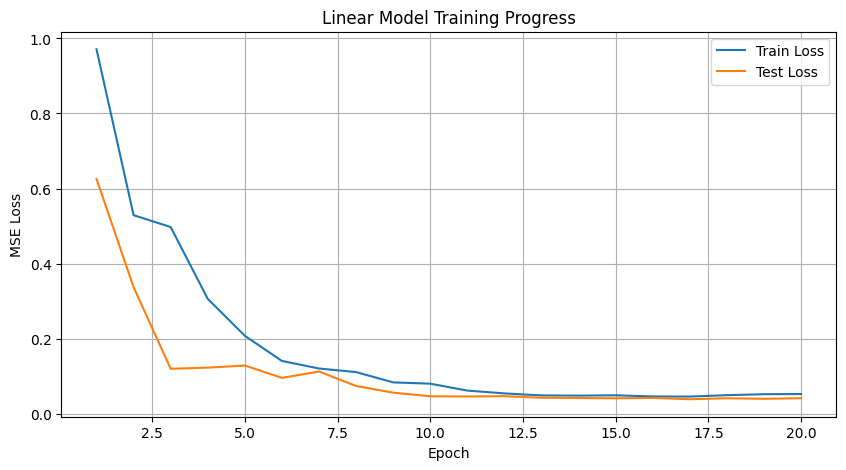

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label="Train Loss")
plt.plot(epochs, testing_losses, label="Test Loss")
plt.title("Linear Model Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_curve.png")

print("\nTraining curve saved as 'training_curve.png'")


In [13]:
print(epochs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
